# Tethered Bead Data Analysis

Import necessary packages.

In [1]:
from __future__ import division, unicode_literals, print_function
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame, Series, HDFStore
import beadpy
import parameters as params

Set plotting preferences.

In [2]:
%matplotlib notebook
mpl.rc('figure',  figsize=(8, 5))
mpl.rc('image', cmap='gray')
#mpl.rc('figure', edgecolor='black')

View parameter settings.

In [3]:
fname = 'parameters.py'
with open(fname, 'r') as fin:
    print(fin.read())

sequencelocation = str('G:/Flynn/20170307LCoreChewPreassembleNoWash/13-24-53.804.seq')
framecut = 10
method = 'parallel' #Set method to 'streaming' or 'parallel'. If parallel, remember to start the ipcluster.
exposuretime = 1 #seconds per frame.
ntmicron = 2805 #Nucleotides per micron (use 2805 for 2.8 micron beads at 15 ul/min in the standard flow cell).
#micronpixel = 0.8 # Microns per pixel.
mintrajlength = 500 #Minimum trajectory duration, in frames.
minrate = 1 #Minimum rate segments to display in segments plot, and also for event filtering.
maxrate = 25 #Maximum rate to display in segments plot, and also for event filtering and the rate plot.
mindisplacement = 1000 #minimum displacement for event filtering.
starttime = 200 #Minimum start time (seconds) for event filtering.
endtime = 15000 #Maximum end time (seconds) for event filtering (normally just leave as a high number).
coarsesigma = 500 #Coarse grained sigma value for event identification and scatter plot.
finesigma = 500 #

Set up the parallel processing client, if needed.

In [8]:
if params.method == 'parallel':
    import ipyparallel
    from ipyparallel import Client
    client = Client()
    view = client.load_balanced_view()
    %%px
    import trackpy as tp
    len(client)

Open the image sequence, crop each image and do a bandpass filter (not applied until the image is called).

In [12]:
import pims
import trackpy as tp

def crop(img):
    x_min = params.xmincrop
    x_max = params.xmaxcrop
    y_min = params.ymincrop
    y_max = params.ymaxcrop
    as_grey=True
    img = tp.bandpass(img, lshort=1, llong = 4)
    return img[y_min:y_max,x_min:x_max]
frames = pims.open(params.sequencelocation,process_func=crop)

Frame([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  1.00194148,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.00483943, ...,  1.17306373,
         1.02585214,  0.        ],
       ..., 
       [ 0.        ,  1.26618059,  1.40238429, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  1.10355122,  1.26482047, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  1.04913095,  1.1893778 , ...,  0.        ,
         0.        ,  0.        ]])
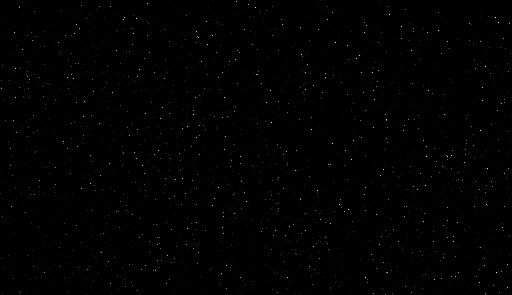

In [13]:
frames[0]

Look for the beads in the first frame.

In [14]:
f = tp.locate(frames[0], 15, invert=False, 
              minmass = 800, 
              separation = 5,
              max_iterations=5, 
              characterize=False, 
              engine='numba', 
              preprocess=False)

<IPython.core.display.Javascript object>


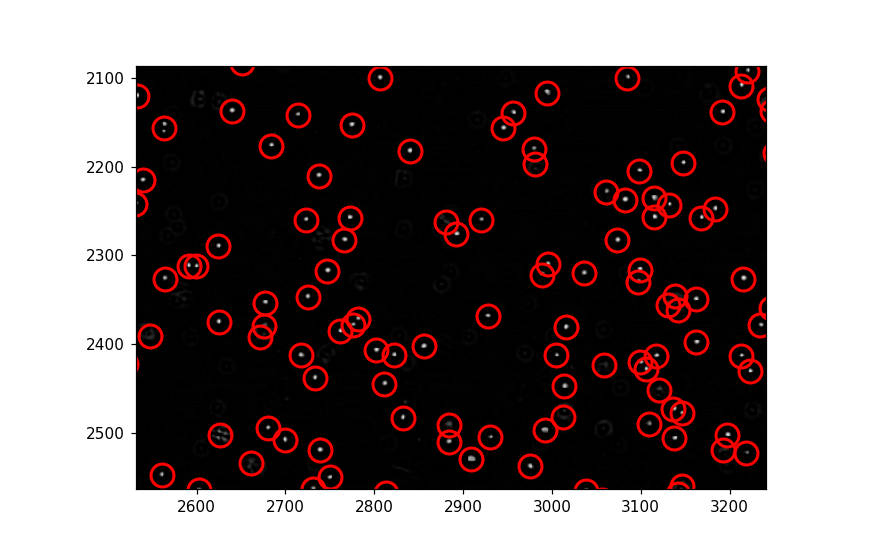

In [15]:
plt.figure()  # make a new figure
tp.annotate(f, frames[0]);
#Zoom in and check that it looks reasonable.

<IPython.core.display.Javascript object>


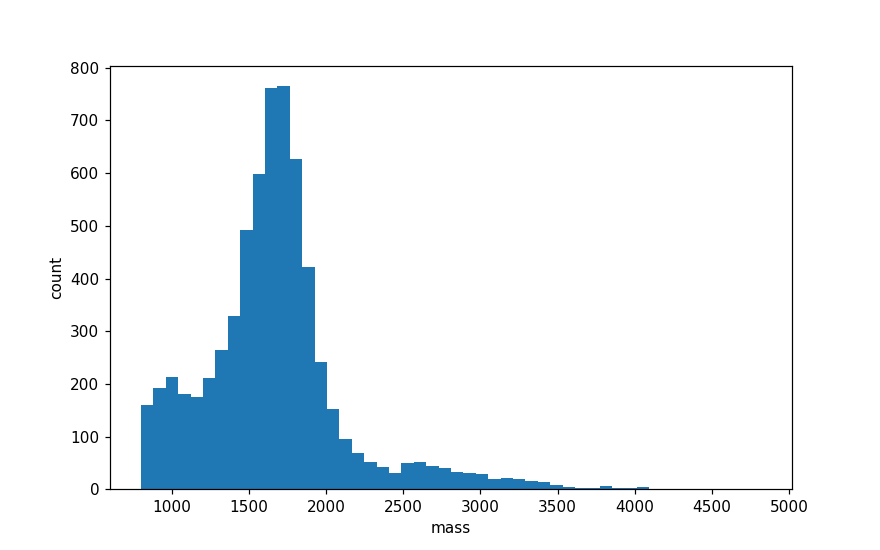

In [16]:
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=50)

# Optionally, label the axes.
ax.set(xlabel='mass', ylabel='count');

In [17]:
len(f)

6484

Inspect the above histogram and adjust the minimum mass value as desired for the bead locating step below.

Locate all beads in all frames, in either parallel or sequential mode (which streams from an hdf5 file and uses a single core).

In [ ]:
if params.method == 'streaming':
   with tp.PandasHDFStore('results.h5') as s:
      for image in frames[:-params.framecut]:
         features = tp.locate(image, 
            15,
            invert=False, 
            minmass = 800, 
            separation = 5,
            max_iterations=5, 
            characterize=False, 
            engine='numba', 
            preprocess=False)
         s.put(features)
elif params.method == 'parallel':
   curried_locate = lambda image: __import__('trackpy').locate(image, 
            15, 
            invert=False, 
            minmass = 800, 
            separation = 5,
            max_iterations=5, 
            characterize=False, 
            engine='numba', 
            preprocess=False)
   amr = view.map_async(curried_locate, frames[:-params.framecut])
   amr.wait_interactive()
   rtemp = amr.get()
   results = pd.concat(rtemp)
   del rtemp
   with tp.PandasHDFStoreBig('results.h5') as s:
      for frameno in results.frame.unique():
         frameres = results[results.frame == frameno]
         s.put(frameres)
   del results

Link the beads into trajectories.

In [ ]:
with tp.PandasHDFStoreBig('results.h5') as s:
	for linked in tp.link_df_iter(s, 1,memory =1, neighbor_strategy='KDTree'):
		s.put(linked)

Read the hdf5 file into memory as a Pandas Data Frame.

In [21]:
with tp.PandasHDFStoreBig('results.h5') as s:
	results = s.dump()

Remove brief trajectories.

In [22]:
results = tp.filter_stubs(results, 150)

Subtract drift. This works by taking all the trajectories which endure from start to finish, centring these at zero, and then taking the median x and y positions at each timepoint to create a drift trajectory which is subsequently subtracted from each trajectory in the results table.

<IPython.core.display.Javascript object>


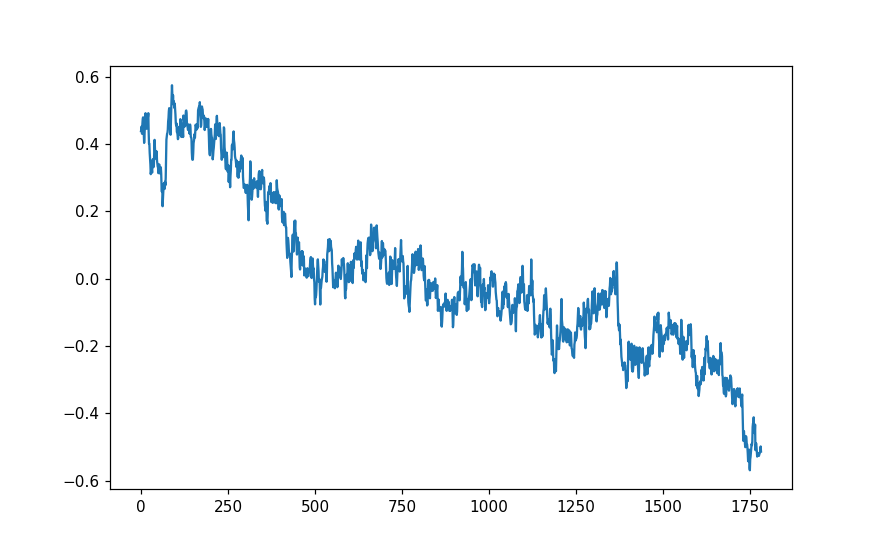

In [24]:
results = beadpy.drift_subtractor(results)

Unit conversion, removal of spurious trajectories (those which do not endure past a certain timepoint), baselining, trajectory renumber.

In [25]:
results = beadpy.unit_converter(results, params.exposuretime, params.ntconversion, params.micronpixel)

In [26]:
results = beadpy.spurious_removal(results)

In [27]:
results = beadpy.baseline(results, params.exposuretime)

In [28]:
results = beadpy.trajectory_renumber(results)

Save the results table.

In [29]:
results.to_csv('pythonresults.csv', index = False, float_format='%.4f')

## Changepoint Analysis

This uses the segment_finder function. Options are:

* datatable

* xcolumn, default = 'time'

* ycolumn, default = 'nucleotides'

* indexcolumn, default = 'trajectory'

* method, options = 'global' or 'auto'. Default 'auto'. Global uses a global sigma value, specified in sigma, auto uses per-trajectory sigma values, calculated within the sigma_start-sigma_end window.

* sigma, default = 500, sigma value used if method = 'global'

* sigma_start, default = 0, start time (xcolumn) for sigma calculation used if method = 'auto'

* sigma_end, default = 100, end time (xcolumn) for sigma calculation used if method = 'auto'

* traj, default = 'none', specify an integer to analyse only a single trajectory.

In [6]:
segments = beadpy.segment_finder(results, sigma = params.coarsesigma)

Segments plotter, the input is: 

1) segments table, 
2) max rate cutoff, 
3) y axis minimum, 
4) y axis maximum, 
5) legend location, 
6) scaling factor for the size of the scatter points (adjust depending on the rates of the events).

<IPython.core.display.Javascript object>


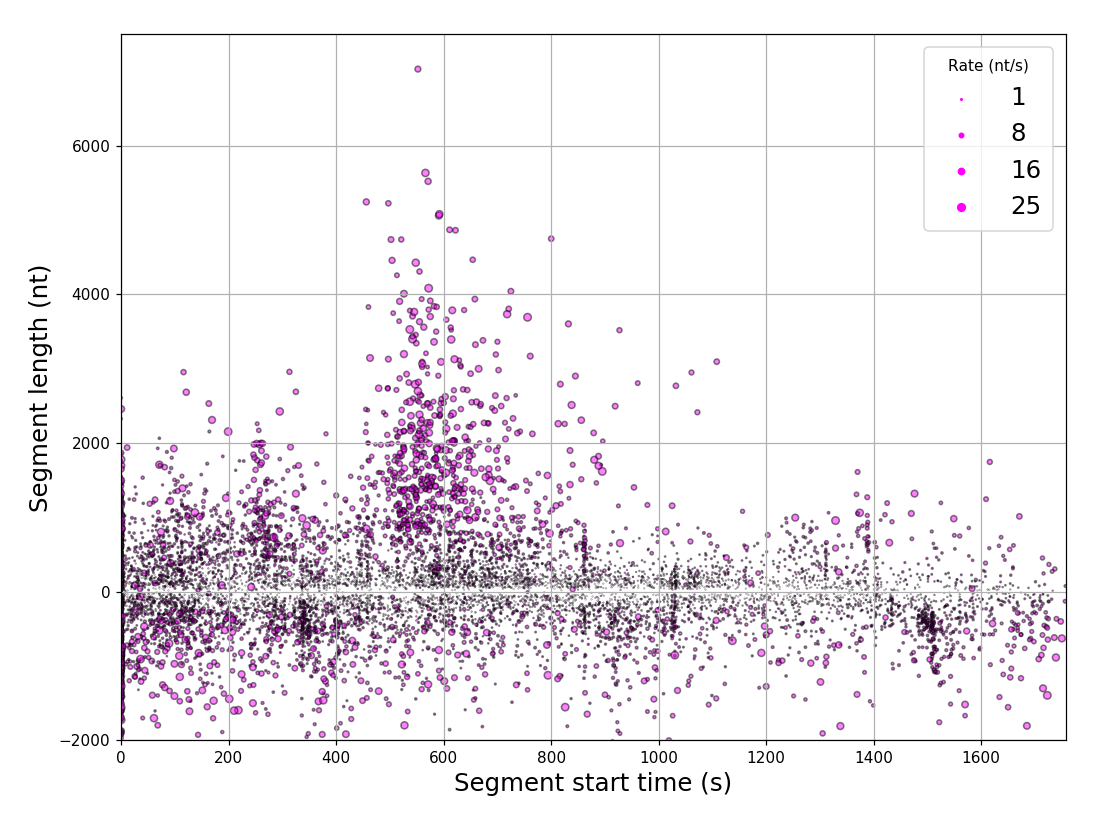

In [9]:
beadpy.segmentplotter(segments,params.maxrate,-2000,7500, 1, 1)

Now filter for trajectories of interest. The best way to do this is to inspect the above plot and adjust the below parameters as desired. These parameters are: 1) results table, 2) segments table, 3) minimum rate, 4) maximum rate, 5) minimum displacement (in nt), 6) minimum start time, 7) maximum end time.

In [38]:
filtresults, filtsegments = beadpy.filterer(results, segments, params.minrate, 
                                            params.maxrate, 
                                            params.mindisplacement, 
                                            params.starttime, 
                                            params.endtime)

In [40]:
filtresults.trajectory.nunique()
#Number of trajectories in the filtered data set:

584

It is usually best at this point to manually curate the filtered results table using the imagej multiplotter and save it in a file called 'curatedresults.csv'.

In [42]:
curatedresults = pd.read_csv("curatedresults.csv")
curatedresults.trajectory.nunique() #Number of unique trajectories in the manually curated data set:

243

Further filter the filtered segments so that only those in the curated data set are retained. 

In [12]:
curatedsegments = filtsegments[filtsegments.trajectory.isin(curatedresults.trajectory)]

Now do a fine-grained changepoint analysis of the automatically determined event regions of the filtered data set. This will be used to generate the rate histogram. This now uses per-trajectory sigma values calculated from the initial event-free period. Sigma_start and sigma_end should be specified in seconds.

In [13]:
segmentsfine = beadpy.ratefinder_autosigma(curatedresults,curatedsegments, sigma_start = 10, sigma_end = 100)

Alternatively, a global sigma value can be applied using the following function:

In [10]:
#segmentsfine = beadpy.ratefinder(curatedresults,curatedsegments,500)

### Rate Histogram

The last option can be:
* 'duration' to weight segments by duration in time
* 'displacement' to weight segments by displacement in nucleotides
* 'fastest' to select only the fastest segment from each event (with no weighting).
* 'longest' to select only the longest segment from each event (with no weighting).
* 'none' to include all segments, with no weighting.

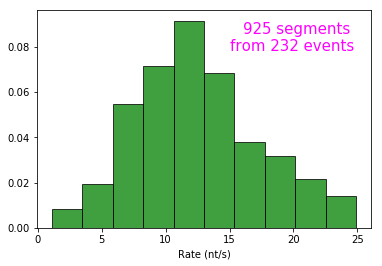

In [14]:
beadpy.ratehist(segmentsfine,params.minrate, params.maxrate, params.ratebins, 'displacement')

### Plot an example trajectory

,rate,intercept,x1,x2,y1,y2,displacement,duration,trajectory
0,1.4,-49.0,0.0,638.0,-49.0,825.7,874.7,638.0,325.0
1,10.4,-5875.0,638.0,1004.0,731.4,4521.3,3790.0,366.0,325.0
2,0.2,4254.0,1004.0,1781.0,4470.9,4638.9,168.0,777.0,325.0


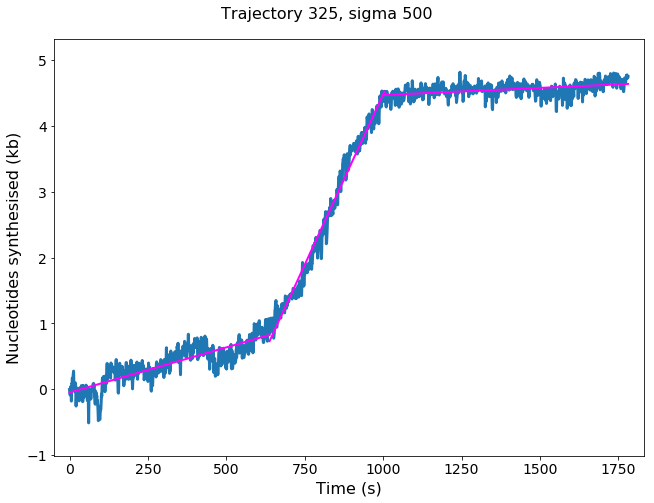

In [11]:
exampletraj = curatedresults.trajectory.unique()[5]
#exampletraj = 68
exampletrajseg = beadpy.trajectory_plotter(curatedresults,exampletraj,params.finesigma)
exampletrajseg

In [13]:
test = beadpy.segment_finder(curatedresults, traj = 639, sigma = 500)

### Processivity Histogram

Input is: 1) Segments table (Should be segments from event portions only), 2) Minimum processivity, 3) Maximum processivity, 4) Number of bins, 5) Number of bins to skip on the left in the fit, 5) Fitting guess in the form of [A,t] (optional)

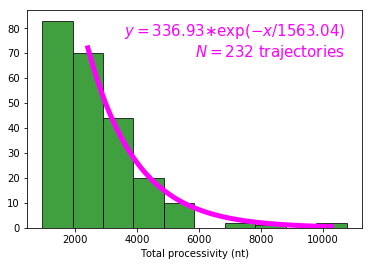

In [16]:
beadpy.processivity(segmentsfine, 0, curatedsegments.displacement.max()*1.5, params.ratebins, 1)

## Optional: Reload saved tables

In [5]:
results = pd.read_csv("pythonresults.csv")

In [3]:
#segments = pd.read_csv("pythonsegments_sigma500.csv") #change sigma value as necessary

In [4]:
#segmentsfine = pd.read_csv("pythonsegments_sigma500.csv") #change sigma value as necessary

In [6]:
filtresults = pd.read_csv("filtresults.csv")

In [4]:
curatedresults = pd.read_csv("curatedresults.csv")

In [5]:
filtsegments = pd.read_csv("filtsegments.csv")